In [29]:
import graspy

import heapq
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import permutations
import networkx as nx
from graspy.simulations import rdpg,sample_edges
from numpy import linalg as LA
from graspy.inference import LatentPositionTest
from graspy.plot import heatmap, pairplot
from graspy.embed import OmnibusEmbed, select_dimension, AdjacencySpectralEmbed, MultipleASE
from scipy.linalg import orthogonal_procrustes
from graspy.utils import import_graph, is_symmetric
from graspy.inference import base
np.random.seed(88889999)

%matplotlib inline

In [30]:
class MMSBM:
    def __init__(self, alpha, nVertices, bernouilli_matrix, sparsity_param=0.):
        self.alpha = alpha
        self.K = len(self.alpha)
        self.nVertices = nVertices
        self.bernMat = bernouilli_matrix
        self.rho = sparsity_param
        properInit = (self.bernMat.shape[0] == self.bernMat.shape[1]) and (self.bernMat.shape[1] == self.K)
        if not properInit:
            raise Exception("Bernoulli marix must be of shape K x K")
        self.vertices=np.zeros((nVertices,self.K))
        self.adjacencyMat=np.zeros((nVertices,nVertices))
        self.Z_left = []
        self.Z_right = []

    def simulateVertices(self):
        for i in range(self.nVertices):
            self.vertices[i,:] = np.random.dirichlet(self.alpha)
        self.vertices = np.array(sorted(self.vertices, key = lambda x: np.argmax(x)))
    
    def simulateMatching(self, Vert1, Vert2):
        z1 = np.random.multinomial(1, Vert1, size=1)
        z1 = z1[0]
        self.Z_left.append(z1)
        z2 = np.random.multinomial(1, Vert2, size=1)
        z2 = z2[0]
        self.Z_right.append(z2)
        probMatching = (1.-self.rho) * z1@(self.bernMat@z2)
        if np.random.rand() < probMatching:
            return 1
        else:
            return 0
    def simulateEdges(self):
        for i in range(self.nVertices):
            for j in range(i,self.nVertices):
                matching_ij = self.simulateMatching(self.vertices[i,:], self.vertices[j,:])
                self.adjacencyMat[i,j] = matching_ij
                self.adjacencyMat[j,i] = matching_ij

    def generateGraph(self, plot = False):
        self.simulateVertices()
        self.simulateEdges()

In [31]:
#define K-Neighrest neighboor function
def KNN(X, k):
    '''This function computes k nearest neighboors of rows of a matrix from the first row and outputs a tuple containing the rows of the knn. X must be a matrix'''
    distance = []
    for i in range(1,len(X)):
        dist = LA.norm(X[i]-X[i-1], ord = 2)
        distance.append(dist)
    smallest_k = heapq.nsmallest(k,((m, n) for n, m in enumerate(distance)))
    _, index_smallest =  zip(*smallest_k)
    index_smallest = np.array(index_smallest)
    return index_smallest
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [36]:
from scipy.linalg import sqrtm

q = 0.3
p = 0.8
d = 4
theta = 0.5 #parameter to fine tune the MMSBM
alpha = theta*np.ones(4)
k = 100 #knearest neighboor 

n = 400 #number of vertices
n_per_block = int(n/d)

time_series = 12

E = 0.3*np.ones((1,d))

B = np.full((d,d), q) - (np.array([q, q, q, q])) * np.identity(d)
diag_B = (np.array([p, p, p, p])) * np.identity(d)

B = B + diag_B

B_sqrt = sqrtm(B)

In [37]:
G = []

MMSBM_g = MMSBM(alpha = alpha, nVertices= n, bernouilli_matrix= B)

MMSBM_g.generateGraph()

g = MMSBM_g.adjacencyMat

G.append(g)

#Need to find latent position, use ASE on single plot (this procedure may cause errors in case just do all the same graphs directly and only use X for perturbation)
embedder_ASE = AdjacencySpectralEmbed(n_components=4)
X = embedder_ASE.fit_transform(G[0])

for j in range(time_series):
    g = rdpg(X)
    G.append(g)

In [38]:
#Need to find latent position, use ASE on single plot
index_to_pert = np.sort(KNN(X, k))

#Now that I have indexes to pertubate matrix, create delta by assigning a d-dimensional vector E to every row in the indexes found, else zero

delta = np.zeros(np.shape(X))

for j in index_to_pert:
    delta[j] = E

#Now perturb time point 6

X_pert6 = X + 0.5 * delta #may need to change theta to a constant

#Now perturb time point 7

X_pert7 = X - 0.5 * delta  #here it may fail beacuse pertubations adds 0.3 and some entries are 0.856

#Finally add perturbed graph back into the time series of graphs

G[5] = rdpg(X_pert6)
G[6] = rdpg(X_pert7)

<AxesSubplot:>

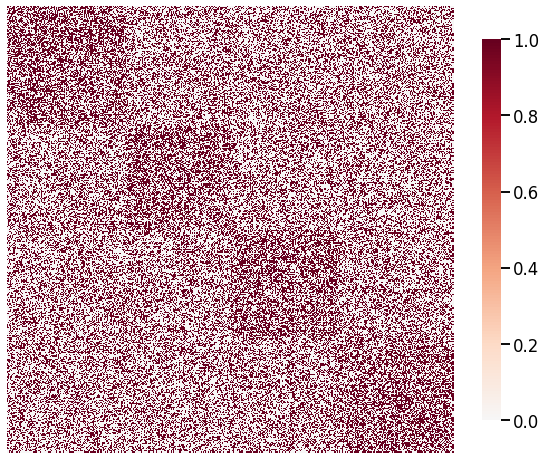

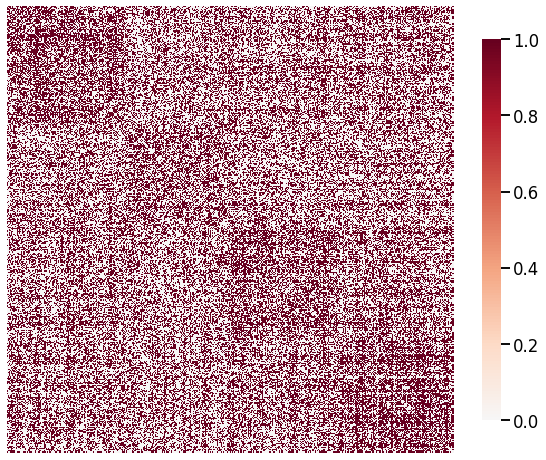

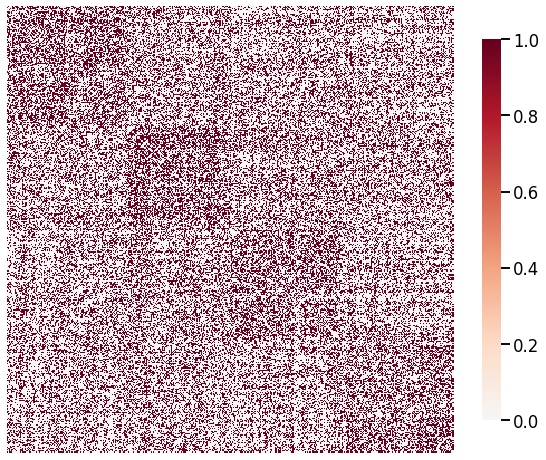

In [39]:
heatmap(G[0])
heatmap(G[5])
heatmap(G[6])

In [19]:
class Detect_Anomaly:
    def __init__(self, n_bootstraps, n_components, embedding):
        self.n_bootstraps = n_bootstraps
        self.n_components = n_components
        self.embedding = embedding

    def _difference_norm(self, X1, X2):
        if self.embedding in ["ase"]:
            if self.test_case == "rotation":
                R = orthogonal_procrustes(X1, X2)[0]
                return np.linalg.norm(X1 @ R - X2)
            elif self.test_case == "scalar-rotation":
                R, s = orthogonal_procrustes(X1, X2)
                return np.linalg.norm(s / np.sum(X1 ** 2) * X1 @ R - X2)
            elif self.test_case == "diagonal-rotation":
                normX1 = np.sum(X1 ** 2, axis=1)
                normX2 = np.sum(X2 ** 2, axis=1)
                normX1[normX1 <= 1e-15] = 1
                normX2[normX2 <= 1e-15] = 1
                X1 = X1 / np.sqrt(normX1[:, None])
                X2 = X2 / np.sqrt(normX2[:, None])
                R = orthogonal_procrustes(X1, X2)[0]
                return np.linalg.norm((X1 @ R - X2), ord = 2)
        else:
            # in the omni case we don't need to align
            return np.linalg.norm(X1 - X2, ord = 2)

    def _embed(self,G1,G2):
        if(self.embedding == "mase"):
            #embedder_MASE = MultipleASE(n_components=self.n_components) try both
            embedder_MASE = MultipleASE()
            V = embedder_MASE.fit_transform((G1,G2)) #may be an issue with mase, down't recover entirely the graph
            R = embedder_MASE.scores_
            Q, D, _ = np.linalg.svd(R[0])
            D = D*np.identity(len(D))
            D_sqrt = sqrtm(D)
            X1 = V @ Q @ D_sqrt
            Q, D, _ = np.linalg.svd(R[1])
            D = D*np.identity(len(D))
            D_sqrt = sqrtm(D)
            X2 = V @ Q @ D_sqrt
            return(X1,X2)
        elif(self.embedding == "ase"):
            #embedder_ASE1 = AdjacencySpectralEmbed(n_components=self.n_components) try both
            embedder_ASE1 = AdjacencySpectralEmbed()
            #embedder_ASE2 = AdjacencySpectralEmbed(n_components=self.n_components) try both
            embedder_ASE2 = AdjacencySpectralEmbed()
            X1 = embedder_ASE1.fit_transform(G1)
            X2 = embedder_ASE2.fit_transform(G2)
            return(X1,X2)
        elif(self.embedding =="omnibus"):
            #embedder_OMNI = OmnibusEmbed(n_components=self.n_components) try both
            embedder_OMNI = OmnibusEmbed()
            Zhat = embedder_OMNI.fit_transform((G1,G2))
            X1 = Zhat[0]
            X2 = Zhat[1]
            return(X1,X2)

    def fit(self,X1,X2):
        y_val_original = self._difference_norm(X1,X2)
        y = []
        X = [X1, X2]
        for i in range(self.n_bootstraps):
            A1 = rdpg(X[0])
            A2 = rdpg(X[1])
            Xhat1, Xhat2 = self._embed(A1,A2)
            X = [Xhat1, Xhat2]
            y_val_boot = self._difference_norm(X[0],X[1])
            y.append(y_val_boot)
        
        y = np.array(y)

        print(y)
        print(y_val_original)

        p_val = len(y[y >= y_val_original]) / float((self.n_bootstraps))

        self.p_value_ = p_val

        return self


In [20]:
Xnew = [X, X_pert6]
print(Xnew[0])

[[ 0.61049493 -0.57393285 -0.41325371 -0.02159606]
 [ 0.62618689 -0.54368952 -0.49487846 -0.14121724]
 [ 0.61737222 -0.24169842 -0.03393974 -0.32737224]
 ...
 [ 0.60899077 -0.05027957  0.33689203 -0.44059175]
 [ 0.61764112  0.14456271  0.52352115 -0.45471533]
 [ 0.65603045  0.12523869 -0.12378191 -0.33213006]]


In [ ]:
detect = Detect_Anomaly(n_bootstraps=100, embedding="omnibus",n_components=d)
detect.fit(X,X_pert6)
print('p = {}'.format(detect.p_value_))

#Detect now works, need to work on embedding each generated graph and use those as inout to the detect anomaly

[2.02403874 1.79577052 1.68371841 1.65835007 1.67864107 1.66174587
 1.6446993  1.63406644 1.57383158 1.61748612 1.58981363 1.61285123
 1.64413797 1.6395187  1.60007364 1.55390395 1.56248393 1.57999575
 1.55061882 1.54456066 1.4809605  1.44933668 1.4641643  1.51393944
 1.54367838 1.48178466 1.53682013 1.52667577 1.50081033 1.54714519
 1.51240104 1.50654501 1.54163619 1.56714827 1.510515   1.44839074
 1.50252922 1.48750646 1.52601351 1.42009945 1.44079951 1.3799402
 1.4127218  1.44437172 1.44059399 1.37962832 1.39228118 1.43671792
 1.42488514 1.46170734 1.5017738  1.5124941  1.58854633 1.56505165
 1.59912485 1.60736854 1.64555684 1.63870556 1.67110131 1.60790651
 1.56149276 1.44018571 1.48211448 1.46344633 1.35301684 1.29943734
 1.32094301 1.39672348 1.3214526  1.37137928 1.33866809 1.37518816
 1.30621857 1.25826245 1.27600072 1.25181081 1.21682031 1.25686538
 1.26784925 1.3089697  1.21214016 1.29759583 1.31672166 1.31995137
 1.38615544 1.33232272 1.29859233 1.32900234 1.29274008 1.31773